In [1]:
import math
import torch
import numpy as np

class RBFSolver():
    def __init__(self):
         self.predict_x0 = True
         pass

    def get_kernel_matrix(self, lambdas, beta):
            # (p, 1)
            lambdas = lambdas[:, None]
            # (p, p)
            K = torch.exp(-beta**2 * (lambdas - lambdas.T) ** 2)
            return K

    def get_integral_vector(self, lambda_s, lambda_t, lambdas, beta):
        
        # Handle the zero-beta case.
        if beta == 0:
            if self.predict_x0:
                return (torch.exp(lambda_t) - torch.exp(lambda_s)) * torch.ones_like(lambdas)
            else:    
                return (torch.exp(-lambda_s) - torch.exp(-lambda_t)) * torch.ones_like(lambdas)
            
        h = lambda_t - lambda_s
        s = 1/(beta*h)
        log_s = torch.log(s)

        # closed-form
        if log_s < 0:
            def log_erf_diff(a, b):
                return torch.log(torch.erfc(b)) + torch.log(1.0-torch.exp(torch.log(torch.erfc(a)) - torch.log(torch.erfc(b))))
    
            r_u = (lambdas - lambda_s) / h
            log_prefactor = lambda_t + torch.log(h) + ((s*h)**2/4 + h*(r_u-1)) + torch.log(0.5*np.sqrt(np.pi)*s)
            upper = (r_u + s**2*h/2)/s
            lower = (r_u + s**2*h/2 - 1)/s
            result = torch.exp(log_prefactor + log_erf_diff(upper, lower))
            return result.float()

        # Gaussian-Legendre Quadrature 10-points
        # Coefficients from from sympy.integrals.quadrature import gauss_legendre
        else:    
            x = torch.tensor([
                -0.973906528517172,
                -0.865063366688985,
                -0.679409568299024,
                -0.433395394129247,
                -0.148874338981631,
                0.148874338981631,
                0.433395394129247,
                0.679409568299024,
                0.865063366688985,
                0.973906528517172,
                ], device=lambdas.device).to(torch.float64)
            w = torch.tensor([
                0.0666713443086881,
                0.149451349150581,
                0.219086362515982,
                0.269266719309996,
                0.295524224714753,
                0.295524224714753,
                0.269266719309996,
                0.219086362515982,
                0.149451349150581,
                0.0666713443086881,
                ], device=lambdas.device).to(torch.float64)
            
            def f1(lam):
                return torch.exp(lam - beta**2*(lam-lambdas[None, :])**2)
            def f2(lam):
                return (lambda_t-lambda_s)/2 * f1(lam*(lambda_t-lambda_s)/2 + (lambda_s+lambda_t)/2)
            
            # (1, p) = (1, n) @ (n, p)
            result = (w[None, :] @ f2(x[:, None]))[0]
            
            return result.float()

    def get_coefficients(self, lambda_s, lambda_t, lambdas, beta):
        lambda_s = lambda_s.to(torch.float64)
        lambda_t = lambda_t.to(torch.float64)
        lambdas = lambdas.to(torch.float64)
        beta = beta.to(torch.float64)

        p = len(lambdas)
        # (p,)
        integral1 = self.get_integral_vector(lambda_s, lambda_t, lambdas, beta)
        # (1,)
        integral2 = self.get_integral_vector(lambda_s, lambda_t, lambdas[:1], beta=0)
        
        # (p+1,)
        integral_aug = torch.cat([integral1, integral2], dim=0)
        #print(integral_aug)

        # (p, p)
        kernel = self.get_kernel_matrix(lambdas, beta)
        eye = torch.eye(p+1, device=kernel.device).to(torch.float64)
        kernel_aug = 1 - eye
        kernel_aug[:p, :p] = kernel
        coefficients = torch.linalg.solve(kernel_aug, integral_aug)
        coefficients = coefficients[:p]  # (p+1,) 중 앞 p개만 슬라이싱
        return coefficients.float()

    def get_lag_kernel_matrix(self, lambdas):
        return torch.vander(lambdas, N=len(lambdas), increasing=True)

    def get_lag_integral(self, a: float, b: float, k: int) -> float:
        if k < 0 or not float(k).is_integer():
            raise ValueError("k must be a non-negative integer.")

        k = int(k)  # 확실하게 int 변환
        k_factorial = math.factorial(k)

        def F(x: float) -> float:
            # F(λ) = -k! * exp(-λ) * Σ_{m=0}^k [λ^m / m!]
            poly_sum = 0.0
            for m in range(k+1):
                poly_sum += (x**m) / math.factorial(m)

            return -k_factorial * math.exp(-x) * poly_sum
        
        def G(x: float) -> float:
            # G(λ) = (-1)^k * k! * exp(λ) * Σ_{m=0}^k [(-λ)^m / m!]
            poly_sum = 0.0
            for m in range(k+1):
                poly_sum += ((-x)**m) / math.factorial(m)

            return (-1)**k * k_factorial * math.exp(x) * poly_sum

        if self.predict_x0:
            return G(b) - G(a)
        else:
            return F(b) - F(a)

    def get_lag_integral_vector(self, lambda_s, lambda_t, lambdas):
        vector = [self.get_lag_integral(lambda_s, lambda_t, k) for k in range(len(lambdas))]
        return torch.tensor(vector, device=lambdas.device)

    def get_lag_coefficients(self, lambda_s, lambda_t, lambdas):
        # (p,)
        integral = self.get_lag_integral_vector(lambda_s, lambda_t, lambdas)
        # (p, p)
        kernel = self.get_lag_kernel_matrix(lambdas)
        kernel_inv = torch.linalg.inv(kernel)
        # (p,)
        coefficients = kernel_inv.T @ integral
        return coefficients
    
    

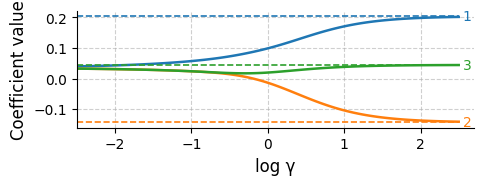

In [2]:
import torch
import matplotlib.pyplot as plt

# 1. Compute coefficients -------------------------------------------------
solver = RBFSolver()                     # 이미 정의돼 있다고 가정
λ_s, λ_t = torch.tensor(0.0), torch.tensor(0.1)
lambdas  = torch.tensor([0.0, -0.1, -0.2])

log_scales = torch.linspace(-2.5, 2.5, 100)
rbf_coeffs = torch.stack([
    solver.get_coefficients(
        λ_s, λ_t, lambdas,
        beta = 1.0 / (torch.exp(lg) * abs(λ_t - λ_s))
    )
    for lg in log_scales
])
adams_coeff = solver.get_lag_coefficients(λ_s, λ_t, lambdas)

# 2. Global style ---------------------------------------------------------
plt.rcParams.update({
    "font.size":       12,
    "axes.labelsize":  12,
    "xtick.labelsize": 10,
    "ytick.labelsize": 10,
    "legend.fontsize": 10,
    "axes.grid":       True,
    "grid.linestyle":  "--",
    "grid.alpha":      0.6,
    "axes.spines.top": False,
    "axes.spines.right": False,
})

# 3. Plot -----------------------------------------------------------------
fig, ax = plt.subplots(figsize=(5, 2))
colors = ['C0', 'C1', 'C2']

for i, c in enumerate(colors):
    # RBF curves
    ax.plot(
        log_scales.numpy(),
        rbf_coeffs[:, i].numpy(),
        linewidth=1.8,
        linestyle="-",
        color=c,
    )
    # Adams lines
    ax.hlines(
        adams_coeff[i].item(),
        log_scales.min().item(),
        log_scales.max().item(),
        linestyle="--",
        linewidth=1.2,
        color=c,
    )
    # Label “1”, “2”, “3” at the right end of each Adams line
    ax.text(
        log_scales.max().item() + 0.05,      # slight offset to the right
        adams_coeff[i].item(),
        f"{i+1}",
        va="center",
        ha="left",
        fontsize=10,
        color=c,
    )

ax.set_xlabel("log γ")
ax.set_ylabel("Coefficient value")
ax.set_xticks([-2.0, -1.0, 0.0, 1.0, 2.0])
ax.set_xlim(-2.5, 2.7)    # extend a bit to show the labels clearly

fig.tight_layout()
plt.show()


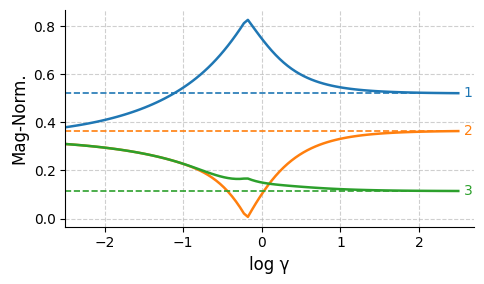

In [3]:
import torch
import matplotlib.pyplot as plt

# 1. Compute coefficients -------------------------------------------------
solver = RBFSolver()                     # 이미 정의돼 있다고 가정
λ_s, λ_t = torch.tensor(0.0), torch.tensor(0.1)
lambdas  = torch.tensor([0.0, -0.1, -0.2])

log_scales = torch.linspace(-2.5, 2.5, 100)
rbf_coeffs = torch.stack([
    solver.get_coefficients(
        λ_s, λ_t, lambdas,
        beta = 1.0 / (torch.exp(lg) * abs(λ_t - λ_s))
    )
    for lg in log_scales
])                                           # (100, 3)

# ── |coeff| → L¹-normalize ──────────────────────────────────────────────
rbf_coeffs = torch.abs(rbf_coeffs)
rbf_coeffs = rbf_coeffs / rbf_coeffs.sum(1, keepdim=True)

adams_coeff = solver.get_lag_coefficients(λ_s, λ_t, lambdas)
adams_coeff = torch.abs(adams_coeff)
adams_coeff = adams_coeff / adams_coeff.sum()      # (3,)

# 2. Global style ---------------------------------------------------------
plt.rcParams.update({
    "font.size":       12,
    "axes.labelsize":  12,
    "xtick.labelsize": 10,
    "ytick.labelsize": 10,
    "legend.fontsize": 10,
    "axes.grid":       True,
    "grid.linestyle":  "--",
    "grid.alpha":      0.6,
    "axes.spines.top": False,
    "axes.spines.right": False,
})

# 3. Plot -----------------------------------------------------------------
fig, ax = plt.subplots(figsize=(5, 3))
colors = ['C0', 'C1', 'C2']

for i, c in enumerate(colors):
    # RBF curves (solid, thicker)
    ax.plot(
        log_scales.numpy(),
        rbf_coeffs[:, i].numpy(),
        linewidth=1.8,
        linestyle="-",
        color=c,
    )
    # Adams reference lines (dashed, thinner)
    ax.hlines(
        adams_coeff[i].item(),
        log_scales.min().item(),
        log_scales.max().item(),
        linestyle="--",
        linewidth=1.2,
        color=c,
    )
    # Label “1”, “2”, “3” at the right end of each Adams line
    ax.text(
        log_scales.max().item() + 0.07,      # 약간 오른쪽으로 띄움
        adams_coeff[i].item(),
        f"{i+1}",
        va="center",
        ha="left",
        fontsize=10,
        color=c,
    )

ax.set_xlabel("log γ")
ax.set_ylabel("Mag-Norm.")
ax.set_xticks([-2.0, -1.0, 0.0, 1.0, 2.0])
ax.set_xlim(-2.5, 2.7)   # 오른쪽 라벨이 잘리지 않도록 살짝 확장

fig.tight_layout()
plt.show()


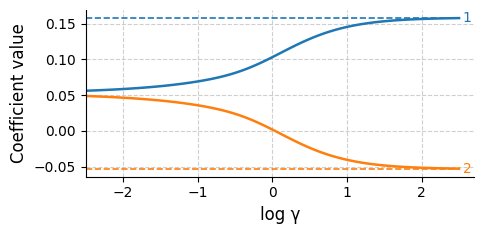

In [4]:
import torch
import matplotlib.pyplot as plt

# 1. Compute coefficients -------------------------------------------------
solver = RBFSolver()                     # 이미 정의돼 있다고 가정
λ_s, λ_t = torch.tensor(0.0), torch.tensor(0.1)

# Two points: λ_t (0.0) and one step back (-0.1)
lambdas = torch.tensor([0.0, -0.1])      # ── 2 coefficients only

log_scales = torch.linspace(-2.5, 2.5, 100)
rbf_coeffs = torch.stack([
    solver.get_coefficients(
        λ_s, λ_t, lambdas,
        beta = 1.0 / (torch.exp(lg) * abs(λ_t - λ_s))
    )
    for lg in log_scales
])                                        # shape: (100, 2)

adams_coeff = solver.get_lag_coefficients(λ_s, λ_t, lambdas)  # shape: (2,)

# 2. Global style ---------------------------------------------------------
plt.rcParams.update({
    "font.size":       12,
    "axes.labelsize":  12,
    "xtick.labelsize": 10,
    "ytick.labelsize": 10,
    "legend.fontsize": 10,
    "axes.grid":       True,
    "grid.linestyle":  "--",
    "grid.alpha":      0.6,
    "axes.spines.top": False,
    "axes.spines.right": False,
})

# 3. Plot -----------------------------------------------------------------
fig, ax = plt.subplots(figsize=(5, 2.5))
colors = ['C0', 'C1']                     # 두 계수만 색 지정

for i, c in enumerate(colors):
    # RBF curves
    ax.plot(
        log_scales.numpy(),
        rbf_coeffs[:, i].numpy(),
        linewidth=1.8,
        linestyle="-",
        color=c,
    )
    # Adams reference lines
    ax.hlines(
        adams_coeff[i].item(),
        log_scales.min().item(),
        log_scales.max().item(),
        linestyle="--",
        linewidth=1.2,
        color=c,
    )
    # Labels “1”, “2” at the right end of Adams lines
    ax.text(
        log_scales.max().item() + 0.05,
        adams_coeff[i].item(),
        f"{i+1}",
        va="center",
        ha="left",
        fontsize=10,
        color=c,
    )

ax.set_xlabel("log γ")
ax.set_ylabel("Coefficient value")
ax.set_xticks([-2.0, -1.0, 0.0, 1.0, 2.0])
ax.set_xlim(-2.5, 2.7)

fig.tight_layout()
plt.show()


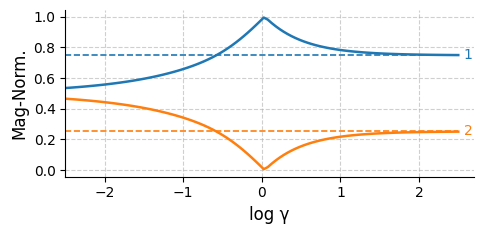

In [5]:
import torch
import matplotlib.pyplot as plt

# 1. Compute coefficients -------------------------------------------------
solver = RBFSolver()                     # 이미 정의돼 있다고 가정
λ_s, λ_t = torch.tensor(0.0), torch.tensor(0.1)

lambdas = torch.tensor([0.0, -0.1])      # ── 두 계수만 사용

log_scales = torch.linspace(-2.5, 2.5, 100)
rbf_coeffs = torch.stack([
    solver.get_coefficients(
        λ_s, λ_t, lambdas,
        beta=1.0 / (torch.exp(lg) * abs(λ_t - λ_s))
    )
    for lg in log_scales
])                                        # (100, 2)

# │coeff│ → L¹-normalize
rbf_coeffs = torch.abs(rbf_coeffs)
rbf_coeffs = rbf_coeffs / rbf_coeffs.sum(1, keepdim=True)

adams_coeff = solver.get_lag_coefficients(λ_s, λ_t, lambdas)  # (2,)
adams_coeff = torch.abs(adams_coeff)
adams_coeff = adams_coeff / adams_coeff.sum()

# 2. Global style ---------------------------------------------------------
plt.rcParams.update({
    "font.size": 12,
    "axes.labelsize": 12,
    "xtick.labelsize": 10,
    "ytick.labelsize": 10,
    "legend.fontsize": 10,
    "axes.grid": True,
    "grid.linestyle": "--",
    "grid.alpha": 0.6,
    "axes.spines.top": False,
    "axes.spines.right": False,
})

# 3. Plot -----------------------------------------------------------------
fig, ax = plt.subplots(figsize=(5, 2.5))
colors = ['C0', 'C1']                     # 두 계수 색상

for i, c in enumerate(colors):
    # RBF curves
    ax.plot(
        log_scales.numpy(),
        rbf_coeffs[:, i].numpy(),
        linewidth=1.8,
        linestyle="-",
        color=c,
    )
    # Adams reference lines
    ax.hlines(
        adams_coeff[i].item(),
        log_scales.min().item(),
        log_scales.max().item(),
        linestyle="--",
        linewidth=1.2,
        color=c,
    )
    # Label “1”, “2” at right end
    ax.text(
        log_scales.max().item() + 0.07,
        adams_coeff[i].item(),
        f"{i+1}",
        va="center",
        ha="left",
        fontsize=10,
        color=c,
    )

ax.set_xlabel("log γ")
ax.set_ylabel("Mag-Norm.")
ax.set_xticks([-2.0, -1.0, 0.0, 1.0, 2.0])
ax.set_xlim(-2.5, 2.7)

fig.tight_layout()
plt.show()


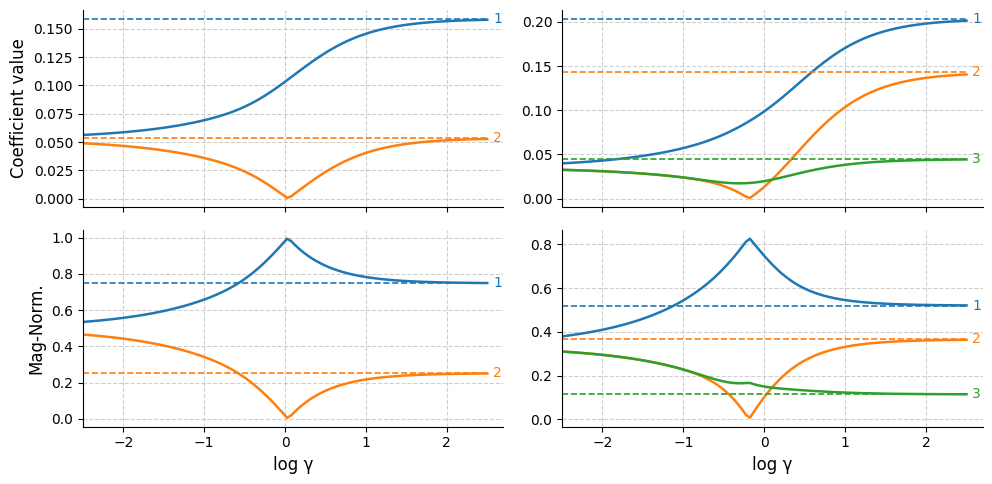

In [6]:
import torch
import matplotlib.pyplot as plt

# ── 0. Solver & common inputs ────────────────────────────────────────────
solver  = RBFSolver()                              # 이미 정의돼 있다고 가정
λ_s, λ_t = torch.tensor(0.0), torch.tensor(0.1)

# 공통 x축
log_scales = torch.linspace(-2.5, 2.5, 100)
x_min, x_max = log_scales.min().item(), log_scales.max().item()

# ── 1. 데이터 준비 함수 ─────────────────────────────────────────────────
def get_coeff_sets(lambdas):
    """raw (abs)와 magnitude-normalized 계수 세트 반환"""
    raw = torch.stack([
        solver.get_coefficients(
            λ_s, λ_t, lambdas,
            beta=1.0 / (torch.exp(lg) * abs(λ_t - λ_s))
        )
        for lg in log_scales
    ])                                           # (100, k)

    adams = solver.get_lag_coefficients(λ_s, λ_t, lambdas)  # (k,)

    # │·│
    raw_abs = torch.abs(raw)
    adams_abs = torch.abs(adams)

    # magnitude-normalized
    raw_norm   = raw_abs / raw_abs.sum(1, keepdim=True)     # (100, k)
    adams_norm = adams_abs / adams_abs.sum()                # (k,)

    return (raw_abs, adams_abs), (raw_norm, adams_norm)

# 2-coeff & 3-coeff 세트
(raw2, adams2_raw), (norm2, adams2_norm) = get_coeff_sets(torch.tensor([0.0, -0.1]))
(raw3, adams3_raw), (norm3, adams3_norm) = get_coeff_sets(torch.tensor([0.0, -0.1, -0.2]))

# ── 2. Style ────────────────────────────────────────────────────────────
plt.rcParams.update({
    "font.size":       12,
    "axes.labelsize":  12,
    "xtick.labelsize": 10,
    "ytick.labelsize": 10,
    "legend.fontsize": 10,
    "axes.grid": True,
    "grid.linestyle": "--",
    "grid.alpha": 0.6,
    "axes.spines.top": False,
    "axes.spines.right": False,
})

# ── 3. Figure (2×2) ─────────────────────────────────────────────────────
fig, axs = plt.subplots(2, 2, figsize=(10, 5), sharex="col")
colors2 = ['C0', 'C1']
colors3 = ['C0', 'C1', 'C2']

# helper to draw a subplot -------------------------------------------------
def draw_subplot(ax, coeff_mat, adams_vec, colors, label_numbers):
    k = coeff_mat.shape[1]
    for i in range(k):
        c = colors[i]
        # RBF curve
        ax.plot(
            log_scales.numpy(),
            coeff_mat[:, i].numpy(),
            linewidth=1.8,
            linestyle="-",
            color=c,
        )
        # Adams reference
        ax.hlines(
            adams_vec[i].item(), x_min, x_max,
            linestyle="--", linewidth=1.2, color=c,
        )
        # 번호 라벨
        ax.text(
            x_max + 0.07, adams_vec[i].item(),
            f"{label_numbers[i]}", va="center", ha="left",
            fontsize=10, color=c,
        )
    ax.set_xticks([-2.0, -1.0, 0.0, 1.0, 2.0])
    ax.set_xlim(-2.5, 2.7)

# ── upper-left: raw 2-coeff ─────────────────────────────────────────────-
axs[0, 0].set_ylabel("Coefficient value")
draw_subplot(axs[0, 0], raw2, adams2_raw, colors2, ["1", "2"])

# ── upper-right: raw 3-coeff ─────────────────────────────────────────────
draw_subplot(axs[0, 1], raw3, adams3_raw, colors3, ["1", "2", "3"])

# ── lower-left: norm 2-coeff ─────────────────────────────────────────────
axs[1, 0].set_ylabel("Mag-Norm.")
axs[1, 0].set_xlabel("log γ")
draw_subplot(axs[1, 0], norm2, adams2_norm, colors2, ["1", "2"])

# ── lower-right: norm 3-coeff ────────────────────────────────────────────
axs[1, 1].set_xlabel("log γ")
draw_subplot(axs[1, 1], norm3, adams3_norm, colors3, ["1", "2", "3"])

fig.tight_layout()
plt.show()


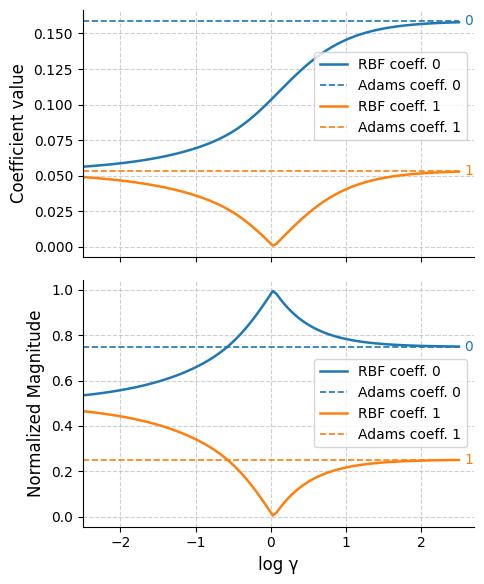

In [19]:
import torch
import matplotlib.pyplot as plt

# ── 0. Solver & common inputs ────────────────────────────────────────────
solver  = RBFSolver()                              # 이미 정의돼 있다고 가정
λ_s, λ_t = torch.tensor(0.0), torch.tensor(0.1)

log_scales = torch.linspace(-2.5, 2.5, 100)
x_min, x_max = log_scales.min().item(), log_scales.max().item()

# ── 1. 계수 계산 (2 coeff) ───────────────────────────────────────────────
lambdas = torch.tensor([0.0, -0.1])                # 두 계수만
raw = torch.stack([
    solver.get_coefficients(
        λ_s, λ_t, lambdas,
        beta=1.0 / (torch.exp(lg) * abs(λ_t - λ_s))
    )
    for lg in log_scales
])                                                 # (100, 2)
adams = solver.get_lag_coefficients(λ_s, λ_t, lambdas)  # (2,)

raw_abs   = torch.abs(raw)
adams_abs = torch.abs(adams)

raw_norm   = raw_abs / raw_abs.sum(1, keepdim=True)
adams_norm = adams_abs / adams_abs.sum()

# ── 2. Style ────────────────────────────────────────────────────────────
plt.rcParams.update({
    "font.size": 12,
    "axes.labelsize": 12,
    "xtick.labelsize": 10,
    "ytick.labelsize": 10,
    "axes.grid": True,
    "grid.linestyle": "--",
    "grid.alpha": 0.6,
    "axes.spines.top": False,
    "axes.spines.right": False,
})

# ── 3. Figure (2×1) ─────────────────────────────────────────────────────
fig, axs = plt.subplots(2, 1, figsize=(5, 6), sharex=True)
colors = ['C0', 'C1']
labels = ["0", "1"]        # 계수 index 표시용

def draw(ax, coeff_mat, adams_vec, ylab):
    for i, c in enumerate(colors):
        ax.plot(
            log_scales.numpy(),
            coeff_mat[:, i].numpy(),
            linewidth=1.8, color=c,
            label=f"RBF coeff. {labels[i]}"
        )
        ax.hlines(
            adams_vec[i].item(), x_min, x_max,
            linestyle="--", linewidth=1.2, color=c,
            label=f"Adams coeff. {labels[i]}"
        )
        ax.text(
            x_max + 0.07, adams_vec[i].item(),
            labels[i], va="center", ha="left",
            fontsize=10, color=c,
        )
    ax.set_ylabel(ylab)
    ax.set_xlim(-2.5, 2.7)
    ax.set_xticks([-2.0, -1.0, 0.0, 1.0, 2.0])

# 위: raw abs
draw(axs[0], raw_abs, adams_abs, "Coefficient value")
axs[0].legend(                # ← 중심보다 약간 위쪽으로
    loc="center right",
    bbox_to_anchor=(1.0, 0.65)   # y-좌표를 0.5 → 0.65 정도로 올림
)

# 아래: magnitude-normalized
draw(axs[1], raw_norm, adams_norm, "Normalized Magnitude")
axs[1].set_xlabel("log γ")
axs[1].legend(loc="center right", bbox_to_anchor=(1.0, 0.5))  # 필요 시 유지/조정

fig.tight_layout()
plt.show()
